Sathvik Reddy V


BL.EN.U4AIE23127


SPEECH PROCESSING LAB 2

In [1]:
!pip install soundfile
!pip install simpleaudio
!pip install librosa
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for simpleaudio
  Running setup.py clean for simpleaudio
Failed to build simpleaudio
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (simpleaudio)


1

1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.display

In [3]:
y, sr = sf.read("/content/LJ037-0171.wav")
Audio(y, rate=sr)

2

In [4]:
num_samples = len(y)
duration = num_samples / sr

print("Sample rate (Hz):", sr)
print("Number of samples:", num_samples)
print("Total duration (sec):", round(duration, 3))

Sample rate (Hz): 22050
Number of samples: 167226
Total duration (sec): 7.584


In [5]:
!pip install transformers datasets torchaudio

3

In [6]:
import torch
import librosa
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

processor = Wav2Vec2Processor.from_pretrained("Bluecast/wav2vec2-Phoneme")
model = Wav2Vec2ForCTC.from_pretrained("Bluecast/wav2vec2-Phoneme")

if sr != 16000:
    y = librosa.resample(y.astype(float), orig_sr=sr, target_sr=16000)
    sr = 16000

input_values = processor(y, sampling_rate=sr, return_tensors="pt").input_values

with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
phoneme_sequence = processor.batch_decode(predicted_ids)

print("Recognized phoneme sequence:")
print(phoneme_sequence[0])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Recognized phoneme sequence:
ah ih g z ae m ah n ey sh ah n ah n d t eh s t ah m ow n iy ah v dhah eh k s p er t s eh n ey b ah l d dh ah k ah m ih sh ah n t uw k ah n k l uw d dh ae t f ay v sh aa t s m ey hh ae v b ih n f ay er d


4

In [16]:
num_frames = logits.shape[1]

total_duration = len(y) / sr
time_per_frame = total_duration / num_frames

frame_ids = torch.argmax(logits, dim=-1)[0].numpy()

token_intervals = []
prev_id = frame_ids[0]
start_frame = 0

for i in range(1, len(frame_ids)):
    if frame_ids[i] != prev_id:
        token_intervals.append((
            prev_id,
            start_frame * time_per_frame,
            i * time_per_frame
        ))
        prev_id = frame_ids[i]
        start_frame = i

token_intervals.append((
    prev_id,
    start_frame * time_per_frame,
    len(frame_ids) * time_per_frame
))

phoneme_intervals = []

current_phoneme = ""
phoneme_start = None
prev_end = None

for pid, start_t, end_t in token_intervals:
    token = processor.tokenizer.convert_ids_to_tokens([int(pid)])[0]

    if token in ["|", "<pad>", "[PAD]"]:
        if current_phoneme != "":
            phoneme_intervals.append(
                (current_phoneme, phoneme_start, prev_end)
            )
            current_phoneme = ""
        continue

    if current_phoneme == "":
        current_phoneme = token
        phoneme_start = start_t
    else:
        current_phoneme += token

    prev_end = end_t

if current_phoneme != "":
    phoneme_intervals.append(
        (current_phoneme, phoneme_start, prev_end)
    )

print("Estimated phoneme time intervals:\n")

for phoneme, start_t, end_t in phoneme_intervals:
    print(
        f"Phoneme: {phoneme:>4} | "
        f"Start: {start_t:.3f}s | End: {end_t:.3f}s"
    )


Estimated phoneme time intervals:

Phoneme:   ah | Start: 0.020s | End: 0.080s
Phoneme:   ih | Start: 0.120s | End: 0.161s
Phoneme:    g | Start: 0.201s | End: 0.221s
Phoneme:    z | Start: 0.241s | End: 0.281s
Phoneme:   ae | Start: 0.341s | End: 0.401s
Phoneme:    m | Start: 0.461s | End: 0.482s
Phoneme:   ah | Start: 0.522s | End: 0.562s
Phoneme:    n | Start: 0.602s | End: 0.622s
Phoneme:   ey | Start: 0.642s | End: 0.702s
Phoneme:   sh | Start: 0.742s | End: 0.782s
Phoneme:   ah | Start: 0.803s | End: 0.863s
Phoneme:    n | Start: 0.883s | End: 0.903s
Phoneme:   ah | Start: 0.923s | End: 0.963s
Phoneme:    n | Start: 0.983s | End: 1.003s
Phoneme:    d | Start: 1.023s | End: 1.043s
Phoneme:    t | Start: 1.083s | End: 1.103s
Phoneme:   eh | Start: 1.144s | End: 1.184s
Phoneme:    s | Start: 1.224s | End: 1.244s
Phoneme:    t | Start: 1.284s | End: 1.304s
Phoneme:   ah | Start: 1.344s | End: 1.384s
Phoneme:    m | Start: 1.404s | End: 1.425s
Phoneme:   ow | Start: 1.465s | End: 1.52

5

In [18]:
labels = list(set([p[0] for p in phoneme_intervals]))

print("Recognized phonemes:")
print(labels)
print()

for phoneme, start_t, end_t in phoneme_intervals:
    if phoneme.strip() != "":
        selected_phoneme = phoneme
        start_time = start_t
        end_time = end_t
        break

start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

phoneme_signal = y[start_sample:end_sample]

print("Selected phoneme:", selected_phoneme)
print(f"Start time: {start_time:.3f} seconds")
print(f"End time: {end_time:.3f} seconds")
print(f"Extracted samples: {len(phoneme_signal)}")


Recognized phonemes:
['p', 'f', 'uw', 'h', 'k', 'ae', 'g', 'eh', 'er', 'ay', 't', 'b', 'n', 's', 'iy', 'ow', 'dhah', 'd', 'm', 'ah', 'dh', 'a', 'ey', 'sh', 'ih', 'l', 'z', 'v']

Selected phoneme: ah
Start time: 0.020 seconds
End time: 0.080 seconds
Extracted samples: 963


6

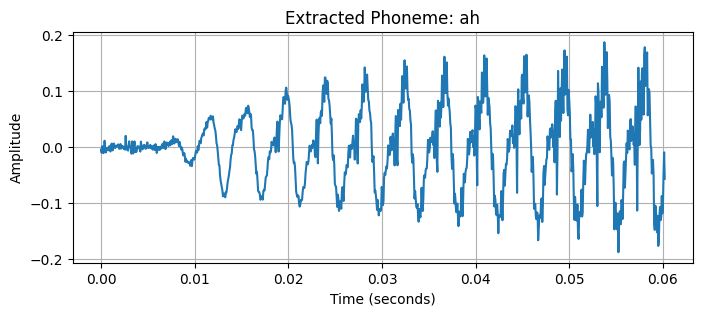

In [19]:
sf.write("extracted_phoneme.wav", phoneme_signal, sr)

t = np.linspace(0, len(phoneme_signal) / sr, len(phoneme_signal))

plt.figure(figsize=(8, 3))
plt.plot(t, phoneme_signal)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Extracted Phoneme: {selected_phoneme}")
plt.grid(True)
plt.show()


7

In [20]:
vowels = ['aa', 'ae', 'ah', 'ao', 'eh', 'er', 'ih', 'iy', 'uh', 'uw']

print("Phoneme-wise source analysis:\n")

for phoneme, start_t, end_t in phoneme_intervals:

    if phoneme.strip() == "":
        continue

    if phoneme in vowels:
        source_type = "Voiced sound (vocal cord vibration)"
    else:
        source_type = "Unvoiced or consonantal sound (airflow obstruction)"

    print(
        f"Phoneme: {phoneme:>4} | "
        f"Start: {start_t:.3f}s | End: {end_t:.3f}s | "
        f"Source: {source_type}"
    )


Phoneme-wise source analysis:

Phoneme:   ah | Start: 0.020s | End: 0.080s | Source: Voiced sound (vocal cord vibration)
Phoneme:   ih | Start: 0.120s | End: 0.161s | Source: Voiced sound (vocal cord vibration)
Phoneme:    g | Start: 0.201s | End: 0.221s | Source: Unvoiced or consonantal sound (airflow obstruction)
Phoneme:    z | Start: 0.241s | End: 0.281s | Source: Unvoiced or consonantal sound (airflow obstruction)
Phoneme:   ae | Start: 0.341s | End: 0.401s | Source: Voiced sound (vocal cord vibration)
Phoneme:    m | Start: 0.461s | End: 0.482s | Source: Unvoiced or consonantal sound (airflow obstruction)
Phoneme:   ah | Start: 0.522s | End: 0.562s | Source: Voiced sound (vocal cord vibration)
Phoneme:    n | Start: 0.602s | End: 0.622s | Source: Unvoiced or consonantal sound (airflow obstruction)
Phoneme:   ey | Start: 0.642s | End: 0.702s | Source: Unvoiced or consonantal sound (airflow obstruction)
Phoneme:   sh | Start: 0.742s | End: 0.782s | Source: Unvoiced or consonantal s